## Objective:
- Fit a One vs All classifier for for different types of variable stars
- Use several different classifier methods: Random Forest, Decision Tree, Logistic Regression, Naive Bayes
- Create a comparision table for different classifiers and labels. Compare using metrics like accuracy, precision and recall

In [1]:
#Load libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle # allows to save differnt trained models of the same classifier object

## Complete features and label table from Xiadian's website

In [2]:
widths = (8,7,4,13,43)
header_pd = pd.read_fwf('Labeled_data.txt', widths = widths,skiprows=7, nrows=27)
labeled_data = pd.read_csv('Labeled_data.txt', header=None, delim_whitespace=True, skiprows=36) # extract data
labeled_data.columns = header_pd.iloc[:,3]
labeled_data.head()
label = labeled_data.Type.unique()
label = np.delete(label, np.where(label == 'CEPII')) # CEPII has very few samples so we ignore it
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'Mira' 'RRc' 'CEP']


## Glossary of different type of variable stars

The 11 different types of variable stars in the data are as follows:
1. <strong> BYDra </strong> : BY Draconis variables are variable stars of late spectral types, usually K or M, and typically belong to the main sequence. 
1. <strong> EW</strong> : EW-type eclipsing binaries (EWs) are W Ursae Majoris-type eclipsing variables with periods shorter than one day.
1. <strong> SR</strong> : semi-regular variables
1. <strong> RSCVN</strong> : An RS Canum Venaticorum variable is a type of variable star. The variable type consists of close binary stars having active chromospheres which can cause large stellar spots.
1. <strong> RR</strong> :RR Lyrae variables are periodic variable stars, commonly found in globular clusters. They are used as standard candles to measure (extra) galactic distances, assisting with the cosmic distance ladder. 
1. <strong> DSCT</strong>: A Delta Scuti variable (sometimes termed dwarf cepheid when the V-band amplitude is larger than 0.3 mag.) is a subclass of young pulsating star. These variables as well as classical cepheids 
1. <strong> EA</strong> : Algol (Beta Persei)-type eclipsing systems. Binaries with spherical or slightly ellipsoidal components. 
1. <strong> Mira</strong> : Mira variables are a class of pulsating stars characterized by very red colours, pulsation periods longer than 100 days, and amplitudes greater than one magnitude in infrared and 2.5 magnitude at visual wavelengths. 
1. <strong> RRc</strong> : RR Lyrae variable stars of subclass c. 
1. <strong> CEP</strong> : A Cepheid variable is a type of star that pulsates radially, varying in both diameter and temperature and producing changes in brightness with a well-defined stable period and amplitude. 
1. <strong> CEPII</strong> : Type II Cepheids are variable stars which pulsate with periods typically between 1 and 50 days. They are population II stars: old, typically metal-poor, low mass objects.

## Import features extracted from light curves
These features are caluclated on 1000 light curves of each variable type. The light curves are imported from variables.cn:88/ . The features are calculated and stored in a .csv file for later use. The .csv file is loaded and used for training the classifier. Below is a brief description of the features calculated to train the models.
Feature list
- <strong>mean</strong> : mean of the light curve
- <strong>wmean</strong> : weight mean of the light curve
- <strong>MAD</strong> : deviation about the median
- <strong>IQR</strong> : inter quartile percentile of the light curve
- <strong>f60</strong> : 60 percentile  of light curve
- <strong>f70</strong> : 70 percentile of the light curve
- <strong>f80</strong> : 80 percentile of the light curve
- <strong>f90</strong> : 90 percentile of the light curve
- <strong>skew</strong> : skewness of the light curve
- <strong>kurtosis</strong> : kurtosis of the light curve
- <strong>welsk_k, welsh_j</strong> : welsh and staton J and K statistics of the light curve
- <strong>g_</strong> : g band filter
- <strong>r_</strong> : r band filter

In [3]:
df = pd.read_csv('features10000.csv', header=None, skiprows=1)
header = pd.read_csv('features10000.csv', header=None, nrows=1)
df.columns = header.iloc[0]

In [4]:
df.head()

,sourceid,ID,RAdeg,DEdeg,g_mean,g_wmean,g_MAD,g_IQR,g_f60,g_f70,...,r_IQR,r_f60,r_f70,r_f80,r_f90,r_skew,r_kurtosis,r_welsh_J,r_welsh_K,Type
0,1.0,ZTFJ000000.13+620605.8,0.000566,62.101631,17.994656,17.992102,0.034,0.07000,0.0820,0.10000,...,0.05125,0.0580,0.06655,0.0797,0.09370,0.105202,-0.632720,40.723268,1678.291273,BYDra
1,2.0,ZTFJ000000.14+721413.7,0.000620,72.237174,19.619402,19.579923,0.111,0.22650,0.2850,0.35950,...,0.22750,0.2712,0.30765,0.3614,0.44115,0.334634,-0.775188,258.579275,3360.702573,EW
2,3.0,ZTFJ000000.19+320847.2,0.000795,32.146449,15.313984,15.313984,0.072,0.14200,0.1580,0.18300,...,0.12600,0.1470,0.16080,0.1760,0.18860,-0.212606,-1.485137,171.745322,891.052032,EW
3,4.0,ZTFJ000000.26+311206.3,0.001085,31.201756,16.353295,16.353295,0.077,0.14900,0.1710,0.18700,...,0.10200,0.1322,0.15980,0.1946,0.20560,0.418285,-1.009552,202.025570,966.503331,EW
4,6.0,ZTFJ000000.30+233400.5,0.001249,23.566828,17.892283,17.878715,0.102,0.18975,0.2526,0.28225,...,0.22900,0.2700,0.29620,0.3132,0.33620,0.158998,-1.484462,253.787215,1019.579800,EW


In [5]:
# Drop rows with Blank values
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(level=None, drop=False, inplace=True)

In [6]:
# get all unique labels
label = df.Type.unique()
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'RRc' 'Mira' 'CEP']


<AxesSubplot:xlabel='Type', ylabel='Count'>

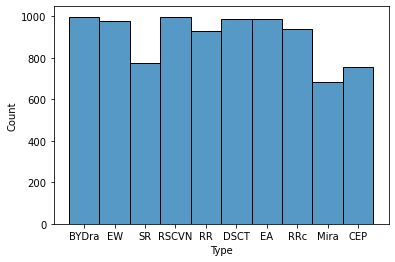

In [7]:
# Plot histogram of variable types in the dataset
import seaborn as sns
sns.histplot(data=df, x=df.Type)

## Various functions to create multiple classifiers

In [8]:
def multiple_to_2labels(df,variable_type):
    """
    converts multiple labels for diffrent variable types to only two labels for one vs all classifier.
    Returns 2 data frames: 
    1. Original data frame with new labels. 
    2. Dataframe with equal candidates of the two classes.
    """
    OneClass = variable_type
    df0 = df.copy()
    df0.loc[df0.Type != OneClass,'Type'] = 'ZZ'
    df1 = df0[df0.Type == 'ZZ']
    df2 = df0[df0.Type == OneClass]

    df3 = df1.sample(n=1000, random_state=1) # balance data type by only selecting 1000 of other type
    frames = [df2,df3]
    df_balanced = pd.concat(frames)
    return df0, df_balanced

In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
def preprocess_data(df):
    """
    Preprocess data for one vs all classifier and split it to train/test data
    """
    # Map string labels to numbers
    label = df.Type

    le = preprocessing.LabelEncoder()
    le.fit(label)

    # Drop columns that are not features
    X = df
    # Encode labels to form y labels
    y = le.transform(df.Type)

    # Split dataset into training set and test set
    X_tr, X_ts, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
    X_train = X_tr.drop(['Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    X_test = X_ts.drop(['Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    return X_train, X_test, y_train, y_test
    

In [10]:

from sklearn import metrics
# from sklearn.metrics import confusion_matrix
def oneVSall_classiffier(name,model,X_train, X_test, y_train, y_test):
    """
    Train Classifier using train dataset. Calculate classifier metrics using test dataset
    """
    #Train the model using the training sets y_pred=clf.predict(X_test)
    if name == ("Isolation Forest" or "One Class SVM"):
        X_train = X_train[y_train==0]
        model.fit(X_train)
    else:
        model.fit(X_train,y_train)

    # Predict test data output
    y_pred = model.predict(X_test)
    
    # Estimate model performance on test data
    if name == "Isolation Forest" or "One Class SVM":
        one_index = np.where(y_pred==1)
        y_pred[one_index] = 1
        negone_index = np.where(y_pred==-1)
        y_pred[negone_index] = 0
    accuracy = metrics.accuracy_score(y_test, y_pred)
    confusion = metrics.confusion_matrix(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
                                      
    return model, accuracy, precision, recall, confusion

## Train and Compare Classifiers

In [11]:
# list of classification methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from sklearn.svm import OneClassSVM

# names = ["Isolation Forest", "One Class SVM", "XG Boost","Random Forest", "Decision Tree", "Logistic Regression", "Naive Bayes"]
clf_names = ["XG Boost","Random Forest", "Decision Tree", "Logistic Regression", "Naive Bayes"]

classifiers = [
#     IsolationForest(contamination=0.01),
#     OneClassSVM(gamma='scale', nu=0.01),
    XGBClassifier(use_label_encoder=False),
    RandomForestClassifier(n_estimators=100),
    DecisionTreeClassifier(criterion="gini", max_depth=3),
    LogisticRegression(solver = 'liblinear',max_iter = 500),
    GaussianNB()]
    


In [12]:
# Run loop to train all classifiers and collect metrics in a dataframe
accuracy ={}
precision = {}
recall = {}
confusion ={}
fitted_models={}

# create comparision dataframe
header = pd.MultiIndex.from_product([clf_names,
                                     ['acc.','preci.','recall']],
                                    names=['classifier','metric'])
index_label = label
pd_comparison = pd.DataFrame(data=None, index=index_label, columns=header, dtype=None, copy=False)
for name in clf_names:
    accuracy[name] = {}
    precision[name] = {}
    recall[name] = {}
    confusion[name] ={}
    fitted_models[name]={}

# train models and collect metrics on test data
for variable_type in label: #loop over different types of variable stars
    print(variable_type)
    df0, df_balanced = multiple_to_2labels(df,variable_type)
    X_train, X_test, y_train, y_test = preprocess_data(df_balanced)
    for name, clf in zip(clf_names, classifiers): # loop over different classifiers
        print(name)
        clf, accuracy[name][variable_type],precision[name][variable_type],recall[name][variable_type], confusion[name][variable_type] = oneVSall_classiffier(name,clf,X_train, X_test, y_train, y_test)
        fitted_models[name][variable_type] = pickle.dumps(clf)
for name in clf_names:        
    pd_comparison.loc[:,(name,'acc.')] = list(accuracy[name].values())
    pd_comparison.loc[:,(name,'preci.')] = list(precision[name].values())
    pd_comparison.loc[:,(name,'recall')] = list(recall[name].values())
    


BYDra
XG Boost
[19:49:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Random Forest
Decision Tree
Logistic Regression
Naive Bayes
EW
XG Boost
[19:49:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Random Forest
Decision Tree
Logistic Regression
Naive Bayes
SR
XG Boost
[19:49:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behav

In [18]:
# print the comparision table
pd_comparison_rounded = pd_comparison.round(decimals=2)
pd_comparison_rounded.head(20)

classifier XG Boost               Random Forest               Decision Tree  \
metric         acc. preci. recall          acc. preci. recall          acc.   
BYDra          0.88   0.93   0.83          0.88   0.92   0.83          0.87   
EW             0.93   0.98   0.90          0.94   0.97   0.91          0.92   
SR             0.91   0.90   0.94          0.89   0.88   0.92          0.83   
RSCVN          0.84   0.92   0.75          0.84   0.91   0.75          0.82   
RR             0.95   0.96   0.94          0.95   0.96   0.95          0.88   
DSCT           0.90   0.92   0.90          0.89   0.90   0.89          0.83   
EA             0.95   0.95   0.95          0.95   0.94   0.96          0.95   
RRc            0.96   0.96   0.95          0.94   0.95   0.93          0.89   
Mira           0.99   0.99   0.99          0.99   0.99   0.99          0.99   
CEP            0.98   0.98   0.98          0.97   0.98   0.97          0.91   

classifier               Logistic Regression               Naive Bayes         \
metric     preci. recall                acc. preci. recall        acc. preci.   
BYDra        0.87   0.86                0.84   0.91   0.76        0.72   0.95   
EW           0.97   0.88                0.89   0.96   0.83        0.74   0.99   
SR           0.83   0.87                0.86   0.86   0.90        0.50   0.85   
RSCVN        0.91   0.72                0.82   0.91   0.71        0.67   0.92   
RR           0.95   0.83                0.92   0.94   0.91        0.80   0.99   
DSCT         0.87   0.80                0.82   0.86   0.79        0.63   0.90   
EA           0.94   0.95                0.95   0.93   0.96        0.69   0.98   
RRc          0.96   0.84                0.92   0.95   0.90        0.77   0.96   
Mira         0.99   0.99                1.00   1.00   1.00        0.99   0.98   
CEP          0.89   0.97                0.94   0.96   0.93        0.78   0.96   

classifier         
metric     recall  
BYDra        0.45  
EW           0.54  
SR           0.17  
RSCVN        0.39  
RR           0.64  
DSCT         0.34  
EA           0.33  
RRc          0.59  
Mira         0.99  
CEP          0.64

In [19]:
pd_comparison.to_csv('comparison_unbalanced.csv')

In [20]:
def preprocess_data2(df):
    """
    Preprocess data for one vs all classifier.
    Return the features dataframe and labels
    """
    # Map string labels to numbers
    label = df.Type

    le = preprocessing.LabelEncoder()
    le.fit(label)

    # Drop columns that are not features
    X = df.drop(['Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    # Encode labels to form y labels
    y = le.transform(df.Type)
    return X, y

In [37]:
def find_probabilities(fitted_models,df,variable_type):
    """
    Push all the data through a 1 vs all classfier. 
    Return the classification probabilities in the two clsses
    """
    df0,df_oneVsAll = multiple_to_2labels(df,variable_type)
    X, y = preprocess_data2(df0)
    clf_XGBoost =  pickle.loads(fitted_models['XG Boost'][variable_type])
#     print(clf_XGBoost.feature_importances_)
    y_prob = clf_XGBoost.predict_proba(X)
    return y_prob

In [40]:
# iterate over 1 vs all XG Boost classifiers for all varaibles and find probabilities
all_probs={}
for variable_type in label:
#     print(variable_type)
    all_probs[variable_type] = find_probabilities(fitted_models,df,variable_type)

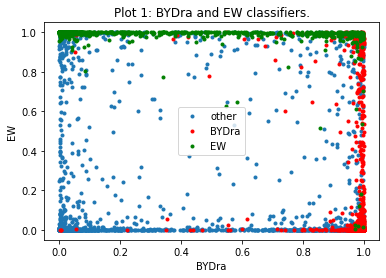

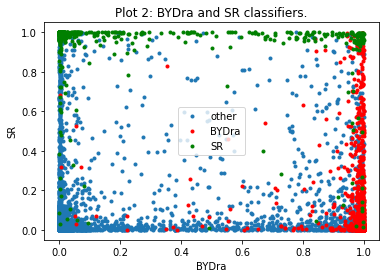

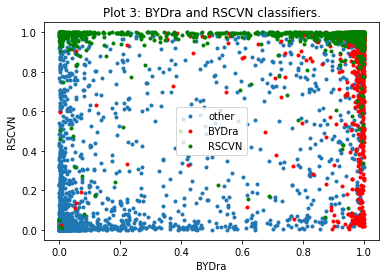

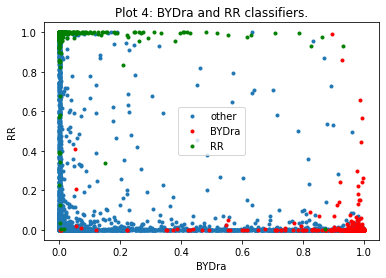

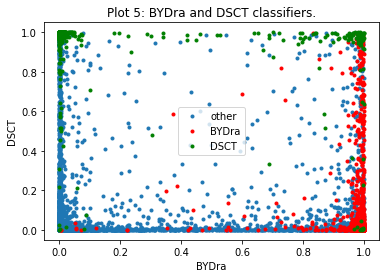

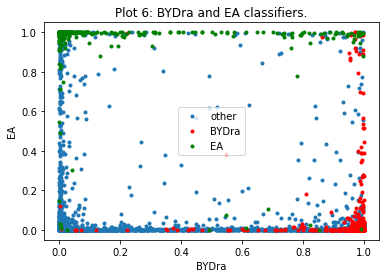

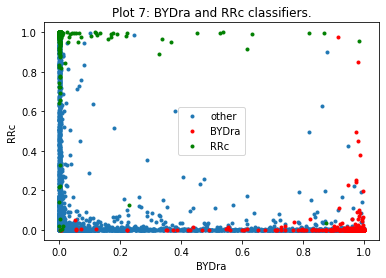

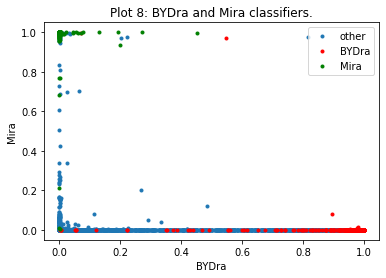

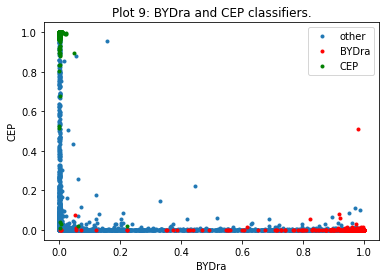

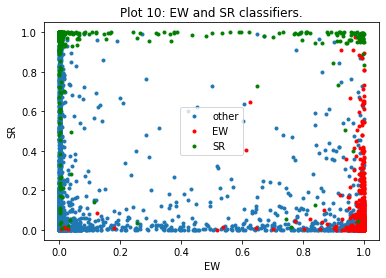

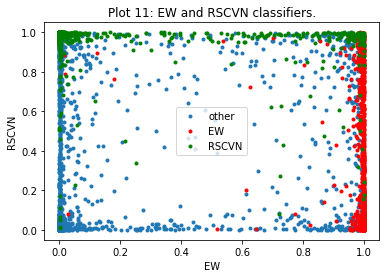

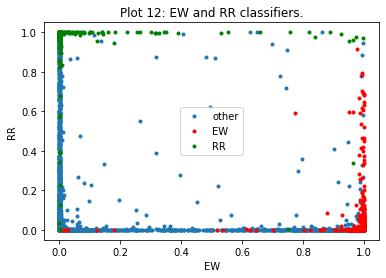

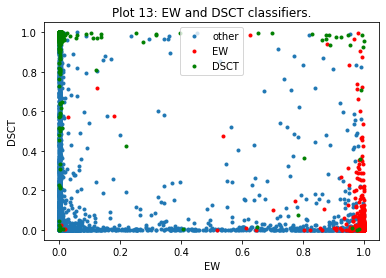

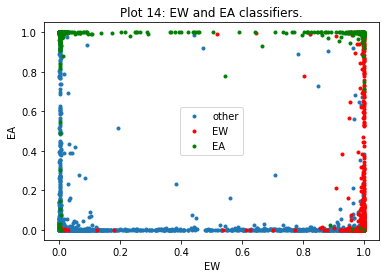

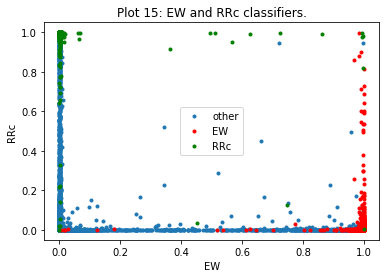

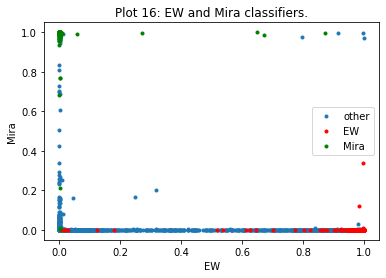

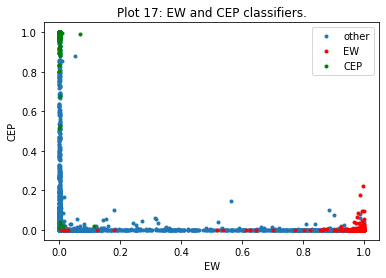

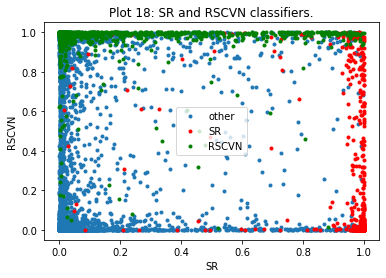

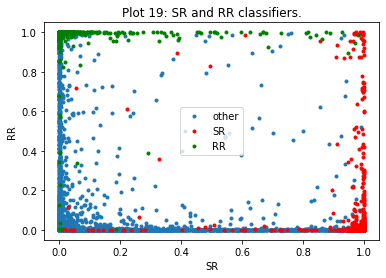

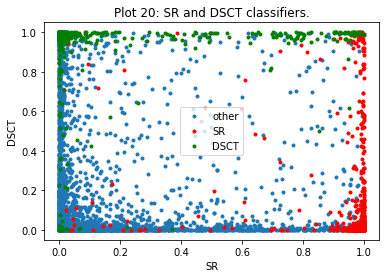

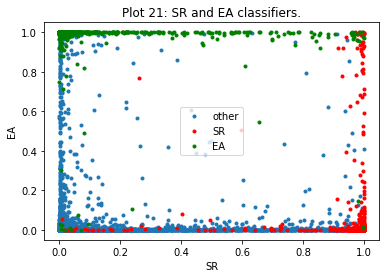

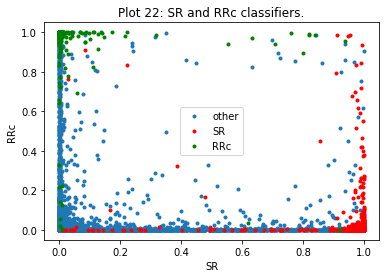

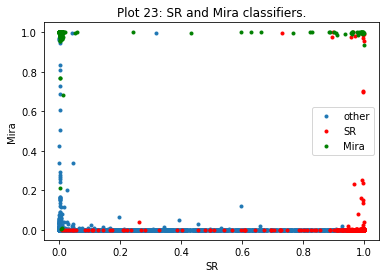

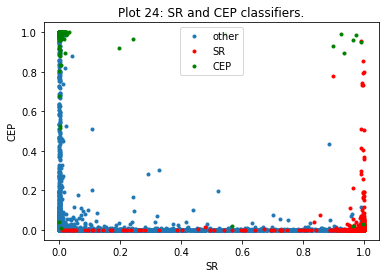

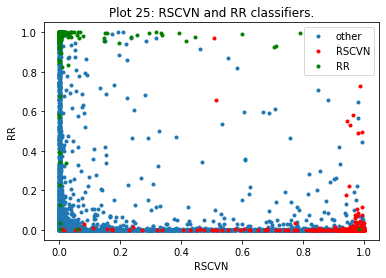

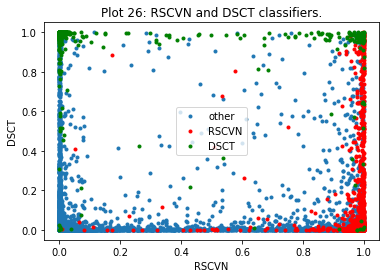

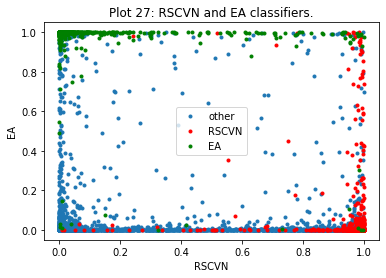

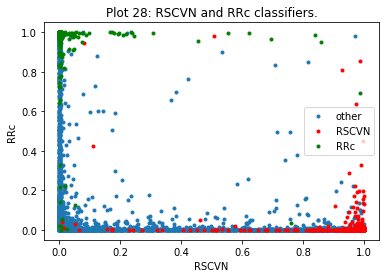

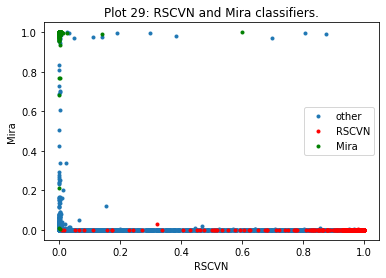

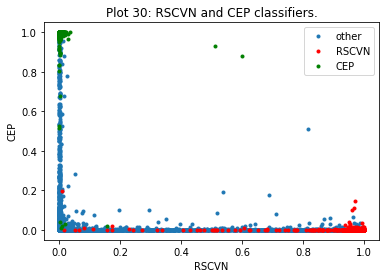

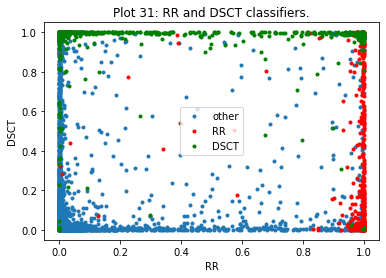

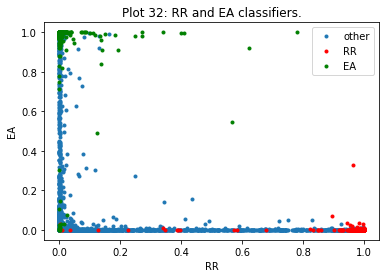

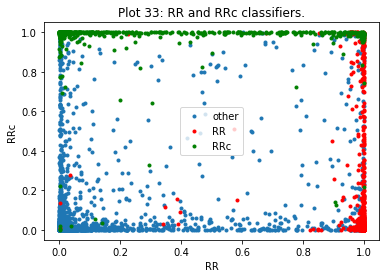

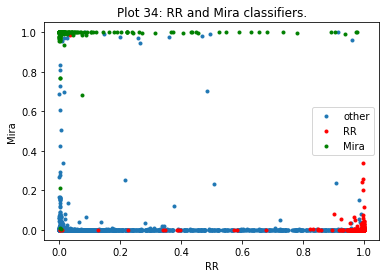

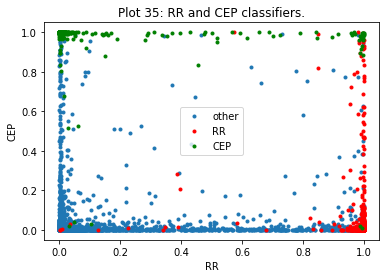

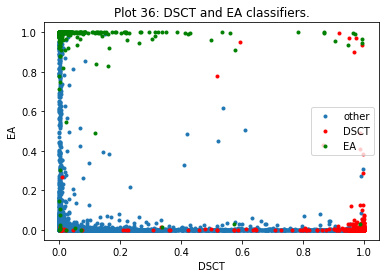

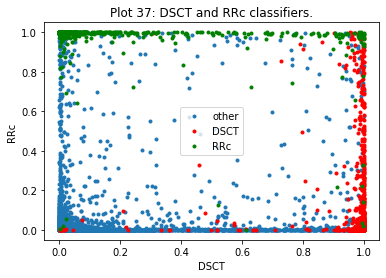

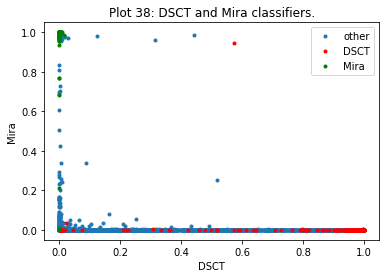

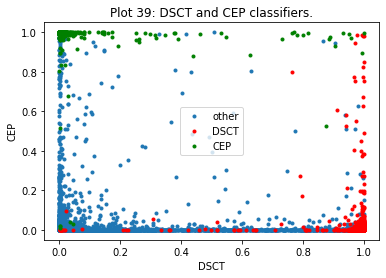

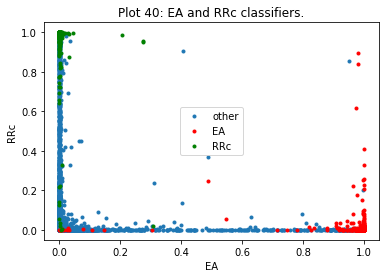

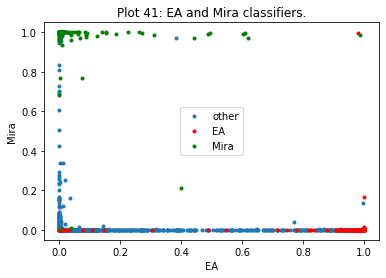

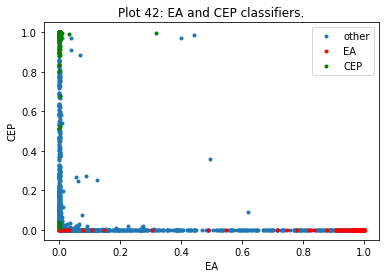

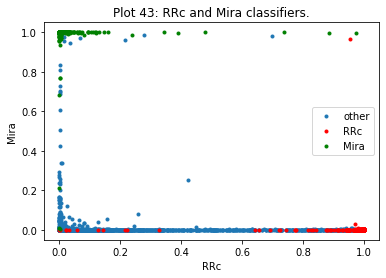

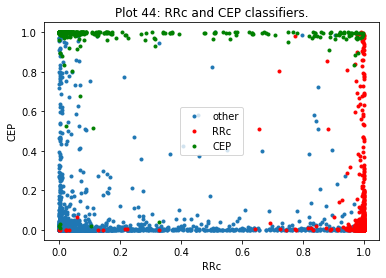

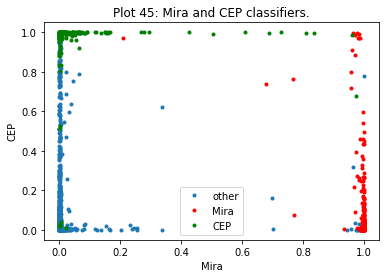

In [41]:
# plot the probabilities from 2 classifiers at a time
n = len(label)
j = 0
for i in range(0,n):
    for k in range(i+1,n):
        j = j+1
        variable_type1 = label[i]
        variable_type2 = label[k]
        prob1 = all_probs[variable_type1][:,0]
        prob2 = all_probs[variable_type2][:,0]
        ind1 = df.index[df['Type']==variable_type1].values
        ind2 = df.index[df['Type']==variable_type2].values
        ind3 = df.index[(df['Type'] != variable_type1) & (df['Type'] != variable_type2)]
        plt.plot(prob1[ind3],prob2[ind3],'.')
        plt.plot(prob1[ind1],prob2[ind1],'r.')
        plt.plot(prob1[ind2],prob2[ind2],'g.')
        plt.xlabel(variable_type1)
        plt.ylabel(variable_type2)
        plt.legend(['other',variable_type1, variable_type2])
        title_string = "Plot {}: {} and {} classifiers.".format(j,variable_type1, variable_type2)
        plt.title(title_string)
        plt.show()
        del ind1, ind2, ind3
        
        

## Notes:
1. Each classifiers was trained on ~2000 balanced datapoints from a total data ~9000 points.
1. Each one vs all classifier had high accuracy, precision and recall (>80% or 90% in most cases) for XG Boost classifier
1. But when we compare how one classifier classifies data from other class using all 9000 data points there are plenty of mis-classification. More than 20% data which is mis-classfied if we consider a probability threshold of 0.5.
1. To improve classification we need to 
    1. Tune the model
    1. Add more features especially pertaining to period calculation
    1. Use more data
1. Preliminary exploration shows Tuning or adding more data doesnot give a big boost to increasing classification accuarcy. Add better features might help.